<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.5
IPython 7.10.2

numpy 1.17.4
scipy 1.3.1
pandas 0.25.3
matplotlib 3.1.1
statsmodels 0.10.1
sklearn 0.21.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


In [3]:
import itertools
import multiprocessing as mp
import os
import pickle
import typing

from time import time
from warnings import filterwarnings

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

%matplotlib inline
pd.set_option('display.max.columns', 25)
filterwarnings('ignore')

In [4]:
PATH_TO_DATA = 'Data/Raw/'
PATH_TO_PICKLED = 'Data/Pickled/'
PATH_TO_MERGED = 'Data/Merged/'
PATH_TO_ANSWERS = 'Answers/'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_PICKLED, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_PICKLED, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_sparse_10users, y_10users,
    test_size=0.3,
    random_state=17,
    stratify=y_10users
)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):

    train_mu = grid_cv_results_['mean_train_score']
    train_std = grid_cv_results_['std_train_score']

    valid_mu = grid_cv_results_['mean_test_score']
    valid_std = grid_cv_results_['std_test_score']

    train_line = plt.plot(
        param_values, train_mu, '-',
        label='train',
        color='green'
    )
    valid_line = plt.plot(
        param_values, valid_mu, '-',
        label='test',
        color='red'
    )
    plt.fill_between(
        param_values, train_mu - train_std, train_mu + train_std,
        edgecolor='none',
        facecolor=train_line[0].get_color(),
        alpha=0.2
    )
    plt.fill_between(
        param_values, valid_mu - valid_std, valid_mu + valid_std,
        edgecolor='none',
        facecolor=valid_line[0].get_color(),
        alpha=0.2 
    )
    plt.legend()


def acc_to_str(train_acc: float, valid_acc: float) -> str:
    return f'{train_acc:.3} {valid_acc:.3}'


def write_answer(answer: str, file_name: str) -> type(None):
    with open(os.path.join(PATH_TO_ANSWERS, file_name), 'w') as out:
        out.write(answer)

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
knn = KNeighborsClassifier(100, n_jobs=-1)

In [11]:
%%time
train_acc = cross_val_score(knn, X_train, y_train, cv=skf).mean()
knn.fit(X_train, y_train)
valid_acc = accuracy_score(knn.predict(X_valid), y_valid)

CPU times: user 12.1 s, sys: 3.75 s, total: 15.9 s
Wall time: 3.96 s


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
__to_write = acc_to_str(train_acc, valid_acc)

write_answer(__to_write, 'week4_1.txt')

print(__to_write)

0.562 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
%%time
forest = RandomForestClassifier(100, n_jobs=-1, random_state=17, oob_score=True).fit(X_train, y_train)

CPU times: user 16.4 s, sys: 136 ms, total: 16.5 s
Wall time: 1.84 s


In [14]:
oob_score = forest.oob_score_
valid_acc = accuracy_score(forest.predict(X_valid), y_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
__to_write = acc_to_str(oob_score, valid_acc)

write_answer(__to_write, 'week4_2.txt')

print(__to_write)

0.72 0.734


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [16]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [17]:
%%time
train_acc = cross_val_score(logit, X_train, y_train, cv=skf).mean()
logit.fit(X_train, y_train)
valid_acc = accuracy_score(logit.predict(X_valid), y_valid)

CPU times: user 4.16 s, sys: 19 ms, total: 4.18 s
Wall time: 1.4 s


In [18]:
__to_write = acc_to_str(train_acc, valid_acc)

write_answer(__to_write, 'week4_3.txt')

print(__to_write)

0.763 0.782


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(
    logit_c_values1,
    multi_class='multinomial',
    random_state=17,
    n_jobs=-1,
    cv=skf
).fit(X_train, y_train)

CPU times: user 4.24 s, sys: 175 ms, total: 4.42 s
Wall time: 6.98 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [20]:
logit_mean_cv_scores1 = next(iter(logit_grid_searcher1.scores_.values())).mean(0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
i = logit_mean_cv_scores1.argmax()

print(
    f'Best accuracy:\t\t{logit_mean_cv_scores1[i]:.3}\n'
    f'Corresponding C:\t{logit_c_values1[i]:.3}'
)

Best accuracy:		0.763
Corresponding C:	4.64


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

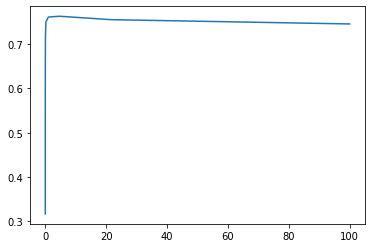

In [22]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.show()

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [23]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(
    logit_c_values2,
    multi_class='multinomial',
    random_state=17,
    n_jobs=-1,
    cv=skf
).fit(X_train, y_train)

CPU times: user 4.9 s, sys: 166 ms, total: 5.07 s
Wall time: 19 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [24]:
logit_mean_cv_scores2 = next(iter(logit_grid_searcher2.scores_.values())).mean(0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [25]:
i = logit_mean_cv_scores2.argmax()
best_logit_C = logit_c_values2[i]

print(
    f'Best accuracy:\t\t{logit_mean_cv_scores2[i]:.3}\n'
    f'Corresponding C:\t{best_logit_C:.3}'
)

Best accuracy:		0.764
Corresponding C:	1.55


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

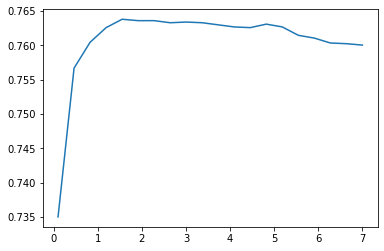

In [26]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [27]:
logit_cv_acc = accuracy_score(
    LogisticRegression(
        C=logit_c_values2[i],
        n_jobs=-1
    ).fit(X_train, y_train).predict(X_valid),
    y_valid
)
print(f'{logit_cv_acc:.3}')

0.784


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [28]:
print(
    acc_to_str(
        logit_grid_searcher2.score(X_train, y_train),
        logit_grid_searcher2.score(X_valid, y_valid)
    )
)

0.885 0.779


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [29]:
%%time
svm = LinearSVC(random_state=17).fit(X_train, y_train)

train_acc = cross_val_score(svm, X_train, y_train, cv=skf).mean()
valid_acc = accuracy_score(svm.predict(X_valid), y_valid)

CPU times: user 4.75 s, sys: 27.3 ms, total: 4.78 s
Wall time: 4.51 s


In [30]:
__to_write = acc_to_str(train_acc, valid_acc)

write_answer(__to_write, 'week4_4.txt')

print(__to_write)

0.756 0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [31]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(
    svm, svm_params1,
    cv=skf,
    return_train_score=True,
    n_jobs=-1
).fit(X_train, y_train)

CPU times: user 2.11 s, sys: 14 ms, total: 2.13 s
Wall time: 9.97 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
__acc_array = svm_grid_searcher1.cv_results_['mean_test_score']
i = __acc_array.argmax()

print(
    f'Best accuracy:\t\t{__acc_array[i]:.3}\n'
    f'Corresponding C:\t{svm_grid_searcher1.cv_results_["param_C"][i]:.3}'
)

Best accuracy:		0.692
Corresponding C:	1.11e+03


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

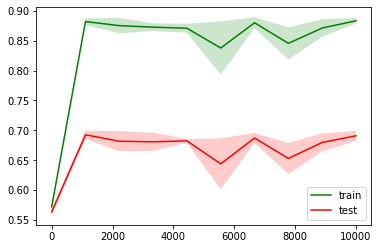

In [33]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [34]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(
    svm, svm_params2,
    cv=skf,
    return_train_score=True,
    n_jobs=-1
).fit(X_train, y_train)

CPU times: user 1.07 s, sys: 26.7 ms, total: 1.1 s
Wall time: 15.3 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [35]:
__acc_array = svm_grid_searcher2.cv_results_['mean_test_score']
i = __acc_array.argmax()
best_C = svm_grid_searcher2.cv_results_["param_C"][i]

print(
    f'Best accuracy:\t\t{__acc_array[i]:.3}\n'
    f'Corresponding C:\t{best_C:.3}'
)

Best accuracy:		0.765
Corresponding C:	0.242


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

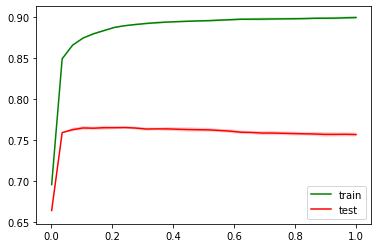

In [36]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [37]:
svm = LinearSVC(C=best_C, random_state=17).fit(X_train, y_train)

valid_acc = accuracy_score(svm.predict(X_valid), y_valid)
print(f'{valid_acc:.3}')

0.784


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [38]:
print(
    acc_to_str(
        svm_grid_searcher2.score(X_train, y_train),
        svm_grid_searcher2.score(X_valid, y_valid)
    )
)

0.879 0.784


In [39]:
svm_grid_searcher2.best_estimator_

LinearSVC(C=0.24213793103448275, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [40]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''

    __time = time()
    X = pd.read_pickle(path_to_X_pickle)
    y = pd.read_pickle(path_to_y_pickle)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    del X, y

    estimator.fit(X_train, y_train)

    train_acc = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    valid_acc = accuracy_score(estimator.predict(X_valid), y_valid)
    return train_acc, valid_acc, time() - __time

**Убедитесь, что функция работает.**

In [41]:
model_assessment(
    svm_grid_searcher2.best_estimator_,
    os.path.join(PATH_TO_PICKLED, 'X_sparse_10users.pkl'),
    os.path.join(PATH_TO_PICKLED, 'y_10users.pkl'),
    skf,
    random_state=17,
    test_size=0.3
)

(0.7649865831742932, 0.7835980090068737, 2.471039056777954)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [42]:
for prefix in ('X_sparse_10users', 'X_sparse_150users', 'y_10users', 'y_150users'):
    symlink = os.path.join(PATH_TO_PICKLED, prefix) + '_s10_w10.pkl'
    if os.path.isfile(symlink):
        os.remove(symlink)
    os.symlink(prefix + '.pkl', symlink)

In [43]:
def run_model_assesment(estimator, window_size: int, session_length: int, n_users: int) -> type(None):
    path_to_X_pkl = os.path.join(
        PATH_TO_PICKLED,
        f'X_sparse_{n_users}users_s{session_length}_w{window_size}.pkl'
    )
    path_to_y_pkl = os.path.join(
        PATH_TO_PICKLED,
        f'y_{n_users}users_s{session_length}_w{window_size}.pkl'
    )
    train_acc, test_acc, exec_time = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
    print(
        f'{window_size}\t{session_length}\t{n_users}\t{train_acc:.3}\t\t{test_acc:.3}\t\t{exec_time:.3}'
    )


def __filtering_rule(x: typing.Tuple[int, int, int]) -> bool:
    (window_size, session_length, _) = x
    return window_size <= session_length

In [44]:
%%time
estimator = svm_grid_searcher2.best_estimator_

print('w_size\ts_len\tn_users\ttrain_acc\ttest_acc\texec_time')

task_pool = mp.Pool(mp.cpu_count())
for (window_size, session_length, n_users) in filter(
    __filtering_rule, itertools.product((10, 7, 5), (15, 10, 7, 5), (10,))
):
    task_pool.apply_async(run_model_assesment, args=(estimator, window_size, session_length, n_users))
task_pool.close()
task_pool.join()

w_size	s_len	n_users	train_acc	test_acc	exec_time
5	5	10	0.725		0.738		4.31
7	7	10	0.752		0.763		4.85
10	10	10	0.765		0.784		5.43
5	7	10	0.773		0.788		6.31
7	10	10	0.8		0.807		6.69
10	15	10	0.824		0.842		6.97
5	10	10	0.818		0.829		8.76
7	15	10	0.85		0.856		9.0
5	15	10	0.872		0.877		11.2
CPU times: user 34.6 ms, sys: 46.5 ms, total: 81 ms
Wall time: 11.3 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [45]:
cvs, test_score, __time = model_assessment(
    LinearSVC(C=best_C, random_state=17),
    os.path.join(PATH_TO_PICKLED, 'X_sparse_10users_s15_w5.pkl'),
    os.path.join(PATH_TO_PICKLED, 'y_10users_s15_w5.pkl'),
    skf
)

__to_write = f'{cvs:.3} {test_score:.3}'
write_answer(__to_write, 'week4_5.txt')
print(__to_write)

0.872 0.877


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [46]:
%%time
estimator = LinearSVC(
    C=svm_grid_searcher2.best_estimator_.C,
    random_state=17
)

print('w_size\ts_len\tn_users\ttrain_acc\ttest_acc\texec_time')

for (window_size, session_length) in ((5, 5), (7, 7), (10, 10)):
    run_model_assesment(estimator, window_size, session_length, 150)

w_size	s_len	n_users	train_acc	test_acc	exec_time
5	5	150	0.41		0.424		3.76e+02
7	7	150	0.437		0.455		2.87e+02
10	10	150	0.46		0.484		2.33e+02
CPU times: user 14min 56s, sys: 1.63 s, total: 14min 57s
Wall time: 14min 55s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [47]:
__to_write = '0.46 0.484'
write_answer(__to_write, 'week4_6.txt')
print(__to_write)

0.46 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [48]:
with open(os.path.join(PATH_TO_PICKLED, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
    X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_PICKLED, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [49]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(
    X_sparse_150users, y_150users,
    test_size=0.3,
    random_state=17,
    stratify=y_150users
)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [50]:
%%time
logit_cv_150users = LogisticRegressionCV(
    Cs=(logit_grid_searcher2.Cs_[10],),
    random_state=17,
    n_jobs=-1,
    multi_class='ovr',
    cv=skf
)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 12min 37s, sys: 4.62 s, total: 12min 42s
Wall time: 3min 38s


LogisticRegressionCV(Cs=(3.7315789473684213,), class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [51]:
cv_scores_by_user = dict(map(lambda x: (x[0], x[1].mean()), logit_cv_150users.scores_.items()))
_tab = '\t'
print(
    '\n'.join(
        map(
            lambda x: f'User {x[0]}\t{_tab if x[0] < 100 else ""}CV score: {x[1]:.3}',
            cv_scores_by_user.items()
        )
    )
)

User 6		CV score: 0.996
User 13		CV score: 0.996
User 15		CV score: 0.995
User 16		CV score: 0.992
User 28		CV score: 0.99
User 31		CV score: 0.994
User 33		CV score: 0.994
User 39		CV score: 0.986
User 46		CV score: 0.998
User 49		CV score: 0.995
User 50		CV score: 0.994
User 53		CV score: 0.994
User 65		CV score: 0.997
User 66		CV score: 0.995
User 82		CV score: 0.996
User 85		CV score: 0.996
User 89		CV score: 0.99
User 92		CV score: 0.994
User 100	CV score: 0.995
User 102	CV score: 0.991
User 103	CV score: 0.981
User 105	CV score: 0.997
User 106	CV score: 0.995
User 118	CV score: 0.991
User 119	CV score: 0.997
User 120	CV score: 0.994
User 126	CV score: 0.995
User 127	CV score: 0.992
User 128	CV score: 0.985
User 138	CV score: 0.997
User 158	CV score: 0.997
User 160	CV score: 0.997
User 165	CV score: 0.997
User 172	CV score: 0.997
User 177	CV score: 0.997
User 203	CV score: 0.998
User 207	CV score: 0.988
User 223	CV score: 0.996
User 233	CV score: 0.996
User 235	CV score: 0.997
Use

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [52]:
user_freqs = np.unique(y_train_150, return_counts=True)[1]
constant_prediction_scores = 1 - user_freqs / user_freqs.sum()
del user_freqs

delta = np.fromiter(cv_scores_by_user.values(), dtype=float) - constant_prediction_scores

In [53]:
num_better_than_default = (delta > 0).sum()
len_delta = len(delta)
print(f'Better than default: {num_better_than_default}/{len_delta}')

Better than default: 121/150


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [54]:
__to_write = f'{num_better_than_default / len_delta:.3}'
write_answer(__to_write, 'week4_7.txt')
print(__to_write)

0.807


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [55]:
y_binary_128 = (y_150users == 128)

In [56]:
def plot_learning_curve(val_train, val_test, train_sizes, xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right')

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [57]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(
    estimator, X_sparse_150users, y_binary_128,
    train_sizes=train_sizes,
    cv=skf,
    n_jobs=-1
)

CPU times: user 862 ms, sys: 106 ms, total: 968 ms
Wall time: 11 s


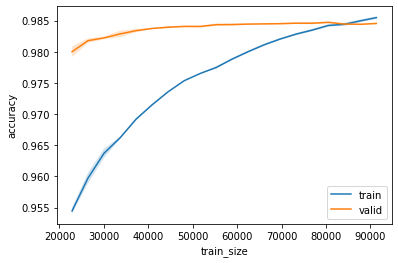

In [58]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.